## Implementing Random-Forest algorithm on Amazon Fine food reviews Dataset 

In [2]:
#IMPORTING ALL RELEVANT LIBRARIES 

import sqlite3
import pandas as pd
import numpy as np

from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.model_selection import GridSearchCV   #Perforing grid search

%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('Agg')
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 7

from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
import itertools
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn import cross_validation
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import warnings
warnings.filterwarnings(action='ignore')

from prettytable import PrettyTable


### Connecting to the pre-processed SQL-ITE Database

In [3]:
#Connecting to the SQL table
con = sqlite3.connect('final.sqlite')

#Reading data from the database

Data = pd.read_sql_query("""
SELECT *
FROM Reviews """,con)
Data.shape

# Drop index column
Data.drop(columns=['index'],inplace=True)


### Setting the database in proper format for further use

In [4]:
Data["Time"]=pd.to_datetime(Data.Time)
Data.head(5)

#Setting Time column as index of the dataframe 
Data.set_index("Time",inplace=True)

#Sampling the above data

Sampled_data=Data.sample(n=100000,replace='False')
Sorted=Sampled_data.sort_index()

Sorted.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Summary,Text,CleanedText
Time,,,,,,,,,,
1970-01-01 00:00:00.944092800,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
1970-01-01 00:00:00.944438400,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...
1970-01-01 00:00:00.947376000,374422,B00004CI84,A1048CYU0OV4O8,Judy L. Eans,2,2,positive,GREAT,THIS IS ONE MOVIE THAT SHOULD BE IN YOUR MOVIE...,one movi movi collect fill comedi action whate...
1970-01-01 00:00:00.948240000,374343,B00004CI84,A1B2IZU1JLZA6,Wes,19,23,negative,WARNING: CLAMSHELL EDITION IS EDITED TV VERSION,"I, myself always enjoyed this movie, it's very...",alway enjoy movi funni entertain didnt hesit p...
1970-01-01 00:00:00.961718400,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,positive,Great Product,This was a really good idea and the final prod...,realli good idea final product outstand use de...


### Plotting the frequency distribution of the class label

In [5]:
Sorted["Score"].value_counts()

positive    84213
negative    15787
Name: Score, dtype: int64

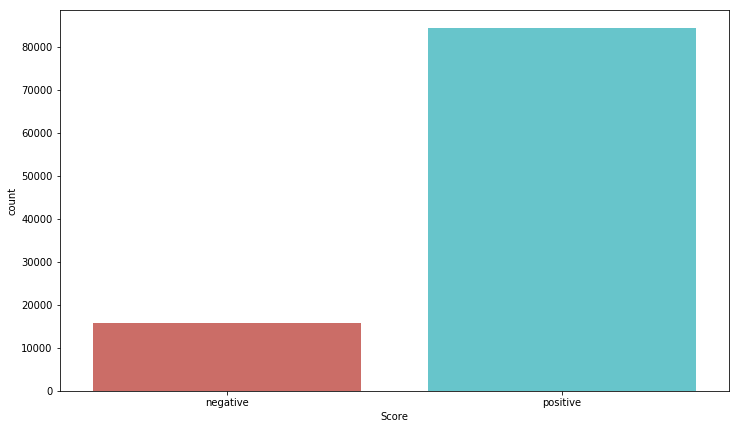

<Figure size 864x504 with 0 Axes>

In [6]:
polarity=Sorted["Score"]
sns.countplot(x="Score",data=Sampled_data,palette="hls")
plt.show()
plt.savefig("count_plot")


<h2>Observations</h2>
<ul>
    <li>Here after all the text-preprocesing and the data-cleaning only 364k datapoints remained.</li>
    <li>I have taken a sample size of 100k and also the whole data out of the total population for the purpose of analyzing and studying the behaviour of the data by applying the Random forest algorithm over it.</li>
    <li>First I took the "TIME" column and set as the index of the new sampled dataframe and then sorted accordingly in ascending order since the data has a temporal nature.</li>
    <li>By setting the "SCORE" column as a class label for classifying the reviews as a positive and negative.</li>
    <li>By observing the above bar plot it is clear that the above dataset is highly imbalanced and this may cause problems in the future analysis.</li>
</ul>
    
    

### Splitting the datapoints into 70:30 split 

In [7]:
def data_split(x,y):
    #Splitting the model into 70:30 split of Training and Cross_validate split
    X_1, X_test, y_1, y_test = train_test_split(X, Y, test_size=0.3,shuffle=False,random_state=None)

# split the train data set into cross validation train and cross validation test
    X_tr, X_cv, y_tr, y_cv = train_test_split(X_1, y_1, test_size=0.3,shuffle=False,random_state=None)
    
    return X_tr,y_tr,X_cv,y_cv,X_test,y_test

### Preparing the data-points for further use 

In [8]:

X=Sampled_data
Y=polarity

X_tr,y_tr,X_cv,y_cv,X_test,y_test=data_split(X,Y)

print("The shape of x_train is:",X_tr.shape)
print("the shape of y_train is:",y_tr.shape)
print("the shape of x_cv is:",X_cv.shape)
print("the shape of y_cv is:",y_cv.shape)
print("the shape of x_test is:",X_test.shape)
print("the shape of y_test is:",y_test.shape)

The shape of x_train is: (49000, 10)
the shape of y_train is: (49000,)
the shape of x_cv is: (21000, 10)
the shape of y_cv is: (21000,)
the shape of x_test is: (30000, 10)
the shape of y_test is: (30000,)


###  Utitlity function for training and cross-validation of the data

In [19]:

#FUNCTION FOR TRAINING THE DATA
def train(X_tr,y_tr,X_cv,y_cv):

    clf = RandomForestClassifier(oob_score=True,n_jobs=-1,class_weight="balanced")

    model=clf.fit(X_tr,y_tr)

    print("The model score on train set is= ", model.score(X_tr,y_tr))

    pred=model.predict(X_cv)

    acc = accuracy_score(y_cv, pred, normalize=True) * float(100)

    print('\nThe accuracy of Random-forest over cross-validation set is =  %d%% ' % ( acc))
    
    return pred,acc
    
    
#FUNCTION FOR PERFORMING HYPER-PARAMETER OPTIMIZATION 
def Gridsearch_tuning(param,x_tr,y_tr):
    
    model = RandomForestClassifier(oob_score=True,n_jobs=-1,class_weight="balanced")
   
    param_grid=param
   
    kfold = TimeSeriesSplit(n_splits=5)
    grid_search = GridSearchCV(model, param_grid, scoring='accuracy', n_jobs=-1, cv=kfold)
    grid_result = grid_search.fit(x_tr, y_tr)
    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))

        
    # plotting results
    scores = np.array(means).reshape(len(n_estimators), len(max_depth))
    for i, value in enumerate(n_estimators):
        plt.plot(max_depth, scores[i], label="n_estimators: " + str(value))
    plt.legend()
    plt.xlabel("Max_depth")
    plt.ylabel('accuracy')
    plt.savefig('n_estimators_vs_depth.png')

    

#FUNCTION FOR TESTING THE MODEL BY USING THE OPTIMAL HYPER-PARAMETERS  
    
def tuned_test( X_tr,y_tr,X_test,y_test,n_est,depth):

    New_clf=RandomForestClassifier(n_estimators=n_est,max_depth=depth,oob_score=True,n_jobs=-1,class_weight="balanced")


    new_model=New_clf.fit(X_tr,y_tr)

    print("The model score on train set is= ", new_model.score(X_tr,y_tr))

    Y_pred=new_model.predict(X_test)

    new_acc = accuracy_score(y_test, Y_pred, normalize=True) * float(100)

    print('\nThe accuracy of the random forest using best parameters over Test set is =  %d%% ' % ( new_acc))

    return Y_pred,new_acc




### Function for Vectorizing the data (BOW & TF-IDF)

In [10]:

#Function for vectorizing the train data
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler(with_mean=False)
from sklearn.feature_extraction.text import TfidfVectorizer

def vec_train(vect,X_tr):
    import warnings
    warnings.filterwarnings("ignore")

    count_vect = vect #in scikit-learn
    BOW = count_vect.fit_transform(X_tr.values)

#Standardizing the vectorized data
    standardized_data = scaler.fit_transform(BOW)
    standardized_data.shape
    return count_vect,standardized_data


#Function for vectorizing the CV data

def vec_cv(count,X_cv):
    cv=count.transform(X_cv.values)
    cv.get_shape()

    std_cv=scaler.transform(cv)
    std_cv.shape
    return std_cv


#Function for vectorizing the test data

def vec_test(count,X_test):
    test=count.transform(X_test.values)
    test.get_shape()

    std_data=scaler.transform(test)
    std_data.shape
    return std_data

#Funtion for printing the total number of top features
def top_tfidf_feats(name,row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', name]
    return df


### Utility function for plotting the confusion matrix 

In [11]:


from sklearn.metrics import confusion_matrix
def Confusion_metric(y_test,y_pred,acc):
    print(metrics.confusion_matrix(y_test,y_pred))
    confusion=metrics.confusion_matrix(y_test,y_pred)

    plt.figure(figsize=(9,9))
    sns.heatmap(confusion, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
    plt.ylabel('Predicted label');
    plt.xlabel('Actual label');
    all_sample_title = 'Accuracy Score: {0}'.format( acc)
    plt.title(all_sample_title, size = 15);
    plt.show()

#Storing the values of the confusion matrix
    TN=confusion[0,0]
    FP=confusion[0,1]
    FN=confusion[1,0]
    TP=confusion[1,1]

# use float to perform true division, not integer division
    Class_acc=((TP + TN) / float(TP + TN + FP + FN))*100

#Code for classification error

    classification_error = ((FP + FN) / float(TP + TN + FP + FN))*100
    

#Code for finding the TPR,FPR,TNR,FNR

    TPR = (TP / float(FN + TP))*100

    FNR = (FN / float(FN + TP))*100

    TNR=(TN / float(TN + FP))*100

    FPR=(FP / float(TN + FP))*100
    
#Code for finding the Precision,Recall & F1_score    
   
    precision = (TP/float(TP+FP))*100
    
    recall= (TP / float(FN + TP))*100
    
    F1_s= ((float(precision*recall)/float(precision+recall))*2)
    
    print()
    
    ptable=PrettyTable()
    ptable.title="The performance metrics of the above model are as follows: "
    ptable.field_names=["Metrics","Scores"]
    ptable.add_row(["Classification_accuracy",Class_acc])
    ptable.add_row(["Classification_error",classification_error])
    ptable.add_row(["True positive",TP])
    ptable.add_row(["False positive",FP])
    ptable.add_row(["True negative",TN])
    ptable.add_row(["False negative",FN])
    ptable.add_row(["True positive rate",TPR])
    ptable.add_row(["False negative rate",FNR])
    ptable.add_row(["True negative rate",TNR])
    ptable.add_row(["False positive rate",FPR])
    ptable.add_row(["Precision value",precision])
    ptable.add_row(["Recall value",recall])
    ptable.add_row(["f1_score value",F1_s])
    
    print(ptable)
    

### Implementing the Bag-of words vectorizer

In [17]:
#Initializing the count vectorizer 
Count_vect=CountVectorizer()

#vectorizing the X_train set
count,x_tr=vec_train(Count_vect,X_tr["CleanedText"])

print("The shape of the X_train is: ",x_tr.shape)

#Vectgorizing the X_crossvalidation set
x_cv=vec_cv(count,X_cv["CleanedText"])
print("The shape of the X_cv is: ",x_cv.shape)


#Vectorizing the X_test set
x_test=vec_test(count,X_test["CleanedText"])
print("The shape of the X_test is: ",x_test.shape)


#Printing the total length of the features
print("\nTop 25 feaures acording to the bow score are as follows",)
features = Count_vect.get_feature_names()
len(features)


top_Bow = top_tfidf_feats("bow",x_tr[1,:].toarray()[0],features,25)
top_Bow




The shape of the X_train is:  (49000, 26189)
The shape of the X_cv is:  (21000, 26189)
The shape of the X_test is:  (30000, 26189)

Top 25 feaures acording to the Bow score are as follows


,feature,bow
0,bedsid,127.805843
1,candybar,66.747397
2,lous,63.906399
3,slip,27.905491
4,macadamia,23.743278
5,factori,23.093906
6,hunger,18.661611
7,betti,18.522939
8,suspect,16.169085
9,purs,15.921680


### Training the model over the cross-validation set with default parameters 

In [18]:
pred,acc=train(x_tr,y_tr,x_cv,y_cv)

The model score on train set is=  0.9768775510204082

The accuracy of Random-forest over cross-validation set is =  81% 


### Confusion matrix of the above model 

[[   69  3500]
 [  433 16998]]


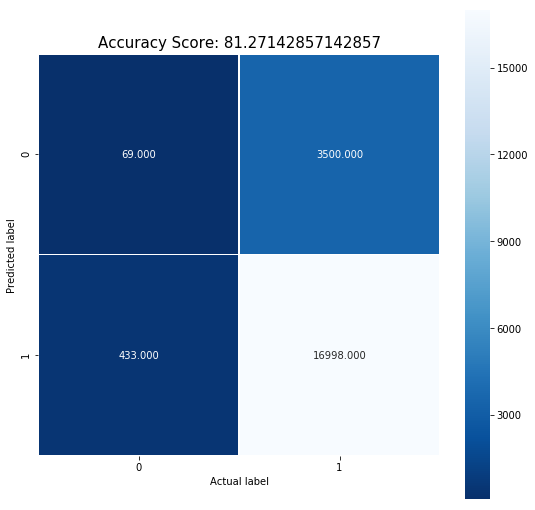


+-------------------------------------------------------------+
| The performance metrics of the above model are as follows:  |
+---------------------------------+---------------------------+
|             Metrics             |           Scores          |
+---------------------------------+---------------------------+
|     Classification_accuracy     |     81.27142857142857     |
|       Classification_error      |     18.728571428571428    |
|          True positive          |           16998           |
|          False positive         |            3500           |
|          True negative          |             69            |
|          False negative         |            433            |
|        True positive rate       |     97.51591991279903     |
|       False negative rate       |     2.484080087200964     |
|        True negative rate       |     1.9333146539646962    |
|       False positive rate       |     98.06668534603531     |
|         Precision value         |    

In [19]:
Confusion_metric(y_cv,pred,acc)

<ul>
    <li>The above model is very bad as the performance metrics of the above Random-forest model with default parameters are very bad and are on lower side.</li>
    <li>I think here the model is over-fitting and can be improved if the hyper-parameters are properly tuned.</li> 

###  Hyper parameter tuning using the Grid-search technique

Best: 0.847098 using {'max_depth': 70, 'n_estimators': 800}
0.744967 (0.045983) with: {'max_depth': 10, 'n_estimators': 100}
0.800171 (0.033037) with: {'max_depth': 10, 'n_estimators': 400}
0.802694 (0.023948) with: {'max_depth': 10, 'n_estimators': 600}
0.806907 (0.024205) with: {'max_depth': 10, 'n_estimators': 800}
0.809233 (0.020279) with: {'max_depth': 10, 'n_estimators': 1000}
0.829855 (0.025988) with: {'max_depth': 36, 'n_estimators': 100}
0.842885 (0.021772) with: {'max_depth': 36, 'n_estimators': 400}
0.842469 (0.022473) with: {'max_depth': 36, 'n_estimators': 600}
0.844012 (0.021530) with: {'max_depth': 36, 'n_estimators': 800}
0.844722 (0.021176) with: {'max_depth': 36, 'n_estimators': 1000}
0.830076 (0.028759) with: {'max_depth': 40, 'n_estimators': 100}
0.843767 (0.020967) with: {'max_depth': 40, 'n_estimators': 400}
0.843889 (0.022501) with: {'max_depth': 40, 'n_estimators': 600}
0.844698 (0.021360) with: {'max_depth': 40, 'n_estimators': 800}
0.845702 (0.020977) with: {'

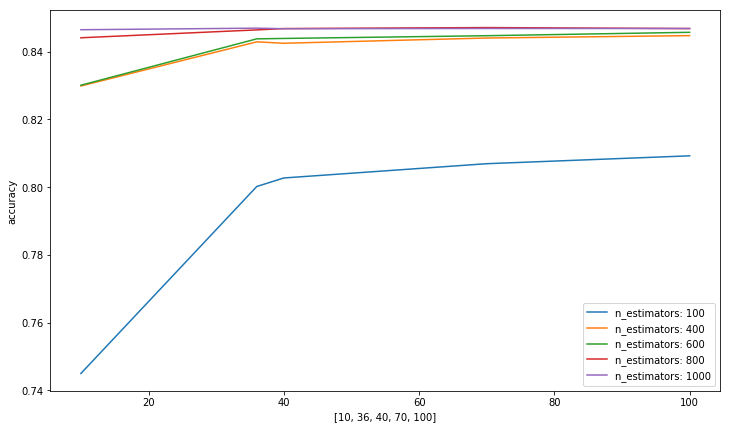

In [21]:
import time
start_time = time.time()

#Tuning the parameters to be given
n_estimators = [100,400,600,800,1000]
max_depth=[10,36,40,70,100]

#Creating dictionary of parameters to be considered
param= dict( n_estimators=n_estimators,max_depth=max_depth)

#Hyperarameter tuning the parameters using Gridsearch cross_validation technique
Gridsearch_tuning(param,x_tr,y_tr)


print("--- %s seconds ---" % (time.time() - start_time))


###  Testing the model with optimal hyperparameters

In [23]:
Y_pred,new_acc=tuned_test( x_tr,y_tr,x_test,y_test,800,70)

The model score on train set is=  0.9646122448979592

The accuracy of the random forest using best parameters over Test set is =  80% 


### Confusion matrix of the above model 

[[  128  5202]
 [  614 24056]]


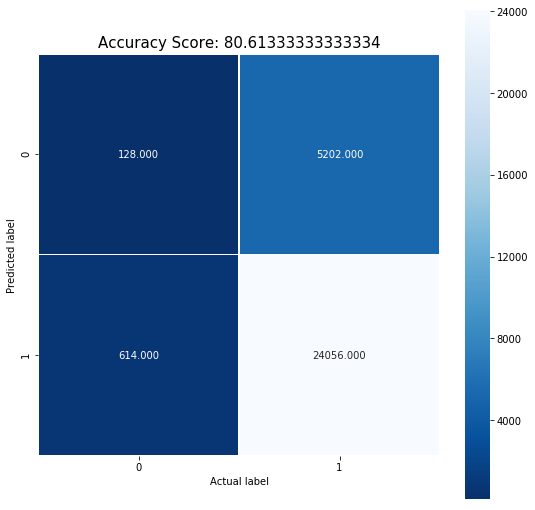


+-------------------------------------------------------------+
| The performance metrics of the above model are as follows:  |
+---------------------------------+---------------------------+
|             Metrics             |           Scores          |
+---------------------------------+---------------------------+
|     Classification_accuracy     |     80.61333333333334     |
|       Classification_error      |     19.386666666666667    |
|          True positive          |           24056           |
|          False positive         |            5202           |
|          True negative          |            128            |
|          False negative         |            614            |
|        True positive rate       |     97.51114714227806     |
|       False negative rate       |     2.4888528577219295    |
|        True negative rate       |     2.401500938086304     |
|       False positive rate       |     97.59849906191369     |
|         Precision value         |    

In [24]:
Confusion_metric(y_test,Y_pred,new_acc)

<h3> OBSERVATIONS</h3>
<ul>
    <li>The optimal depth and the number of base learners after doing Gridsearch is 70 and 800 since Random-forest is a low bias and high variance model this parameters are optimal as the variance should be high.</li>
    <li>The test accuracy with optimal parameters is 80.61% which is quite misleading as the performance metrics of the model are model and the model is not at all sensible.</li>
    <li>Since the decision trees did not work well with the high dimensional text data so here random forest also fails because the underlying base-learners are Decison-trees.
    <li>So Random-forest classiffier does not work well with the text data and on Bag-of-words vectorization technique.</li>

## Implementing the TF-IDF  Vectorization technique

In [14]:
#Initializing the count vectorizer 
TFIDF_vect=TfidfVectorizer(ngram_range=(1,2),min_df=5)

#vectorizing the X_train set
TF,tfx_tr=vec_train(TFIDF_vect,X_tr["CleanedText"])

print("The shape of the X_train is: ",tfx_tr.shape)

#Vectgorizing the X_crossvalidation set
tfx_cv=vec_cv(TF,X_cv["CleanedText"])
print("The shape of the X_cv is: ",tfx_cv.shape)


#Vectorizing the X_test set
tfx_test=vec_test(TF,X_test["CleanedText"])
print("The shape of the X_test is: ",tfx_test.shape)


#Printing the total length of the features
print("\nTop 25 feaures acording to the TF-IDF score are as follows")
TF_features = TFIDF_vect.get_feature_names()
len(TF_features)


top_TFIDF = top_tfidf_feats("TFIDF",tfx_tr[1,:].toarray()[0],TF_features,25)
top_TFIDF



The shape of the X_train is:  (49000, 67776)
The shape of the X_cv is:  (21000, 67776)
The shape of the X_test is:  (30000, 67776)

Top 25 feaures acording to the TF-IDF score are as follows


,feature,TFIDF
0,yes get,158.297420
1,good that,81.158914
2,that tast,77.994181
3,yes tast,76.102594
4,like corn,74.573815
5,job done,62.665035
6,get job,62.509691
7,depth,36.050039
8,yes,24.693449
9,corn syrup,16.574830


### Training the Random forest model over the TF-IDF Vectorized data

In [15]:
tf_pred,tf_acc=train(tfx_tr,y_tr,tfx_cv,y_cv)

The model score on train set is=  0.9749387755102041

The accuracy of Random-forest over cross-validation set is =  81% 


### Confusion matrix of the above model 

[[   79  3500]
 [  389 17032]]


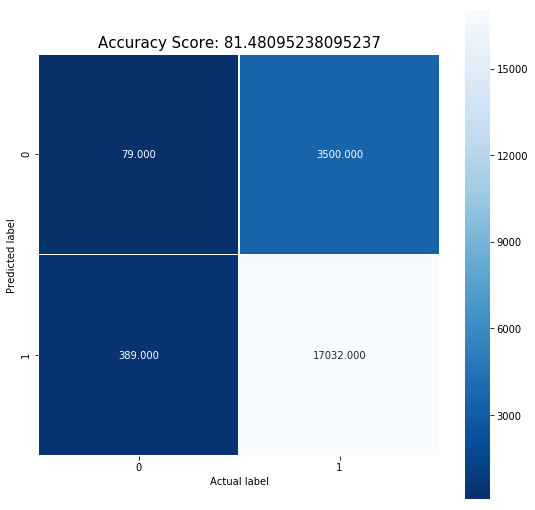


+-------------------------------------------------------------+
| The performance metrics of the above model are as follows:  |
+----------------------------------+--------------------------+
|             Metrics              |          Scores          |
+----------------------------------+--------------------------+
|     Classification_accuracy      |    81.48095238095237     |
|       Classification_error       |    18.51904761904762     |
|          True positive           |          17032           |
|          False positive          |           3500           |
|          True negative           |            79            |
|          False negative          |           389            |
|        True positive rate        |    97.76706274037082     |
|       False negative rate        |    2.232937259629183     |
|        True negative rate        |    2.207320480581168     |
|       False positive rate        |    97.79267951941884     |
|         Precision value          |   

In [16]:
Confusion_metric(y_cv,tf_pred,tf_acc)

<ul>
    <li>The above model is very bad as the performance metrics of the above Random-forest model with default parameters are very bad and are on lower side.</li>
    <li>I think here the model is over-fitting and can be improved if the hyper-parameters are properly tuned.</li> 

###  Hyper parameter tuning using the Grid-search technique

Best: 0.846216 using {'max_depth': 70, 'n_estimators': 800}
0.731154 (0.072967) with: {'max_depth': 10, 'n_estimators': 100}
0.797845 (0.046033) with: {'max_depth': 10, 'n_estimators': 400}
0.801053 (0.045028) with: {'max_depth': 10, 'n_estimators': 600}
0.808940 (0.042125) with: {'max_depth': 10, 'n_estimators': 800}
0.812123 (0.040839) with: {'max_depth': 10, 'n_estimators': 1000}
0.834240 (0.026775) with: {'max_depth': 36, 'n_estimators': 100}
0.843253 (0.020414) with: {'max_depth': 36, 'n_estimators': 400}
0.844208 (0.019704) with: {'max_depth': 36, 'n_estimators': 600}
0.844624 (0.018825) with: {'max_depth': 36, 'n_estimators': 800}
0.844257 (0.019578) with: {'max_depth': 36, 'n_estimators': 1000}
0.836909 (0.025604) with: {'max_depth': 40, 'n_estimators': 100}
0.844624 (0.019088) with: {'max_depth': 40, 'n_estimators': 400}
0.844893 (0.018771) with: {'max_depth': 40, 'n_estimators': 600}
0.845163 (0.018507) with: {'max_depth': 40, 'n_estimators': 800}
0.845677 (0.018262) with: {'

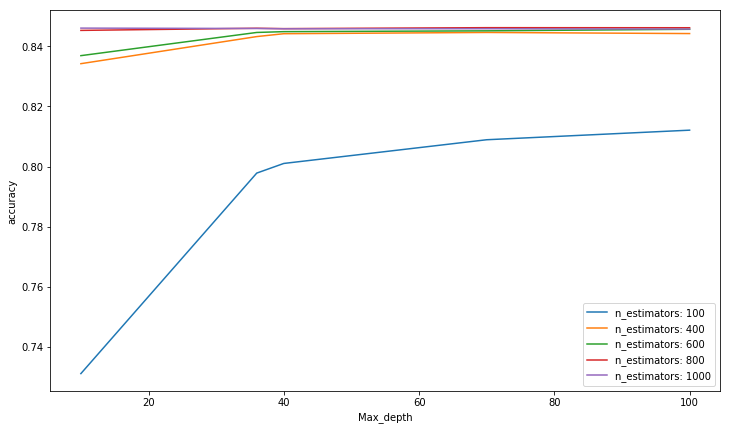

In [34]:
### import time
start_time = time.time()

#Tuning the parameters to be given
n_estimators = [100,400,600,800,1000]
max_depth=[10,36,40,70,100]

#Creating dictionary of parameters to be considered
Param= dict( n_estimators=n_estimators,max_depth=max_depth)

#Hyperarameter tuning the parameters using Gridsearch cross_validation technique
Gridsearch_tuning(Param,tfx_tr,y_tr)


print("--- %s seconds ---" % (time.time() - start_time))


###  Testing the Random-forest  model with optiamal hyper-parameters

In [18]:
Y_Pred,New_acc=tuned_test( tfx_tr,y_tr,tfx_test,y_test,800,70)     

The model score on train set is=  0.9762448979591837

The accuracy of the random forest using best parameters over Test set is =  81% 


### Confusion matrix of the above model

[[   90  5180]
 [  452 24278]]


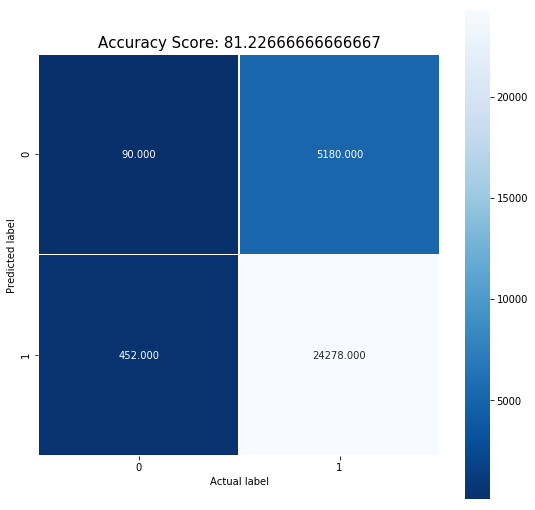


+-------------------------------------------------------------+
| The performance metrics of the above model are as follows:  |
+---------------------------------+---------------------------+
|             Metrics             |           Scores          |
+---------------------------------+---------------------------+
|     Classification_accuracy     |     81.22666666666667     |
|       Classification_error      |     18.773333333333333    |
|          True positive          |           24278           |
|          False positive         |            5180           |
|          True negative          |             90            |
|          False negative         |            452            |
|        True positive rate       |      98.1722604124545     |
|       False negative rate       |     1.8277395875454912    |
|        True negative rate       |     1.7077798861480076    |
|       False positive rate       |      98.292220113852      |
|         Precision value         |    

In [20]:
Confusion_metric(y_test,Y_Pred,New_acc)

<h3> OBSERVATIONS</h3>
<ul>
    <li>The optimal depth and the number of base learners after doing Gridsearch is 70 and 800 since Random-forest is a low bias and high variance model this parameters are optimal as the variance should be high.</li>
    <li>The test accuracy with optimal parameters is 80.61% which is quite misleading as the performance metrics of the model are model and the model is not at all sensible.</li>
    <li>Since the decision trees did not work well with the high dimensional text data so here random forest also fails because the underlying base-learners are Decison-trees.
    <li>So Random-forest classiffier does not work well with the text data and on the TF-IDF vectorization technique because its dImensions are even higher than the  previous Bag-of-Words Vectorization technique.</li>

### Implementing the Average Word 2 vec Vectorization technique

In [21]:
#code for finding the average word2vec

#Utility function for implementing the Average-word2vec-vectorization techniques

import gensim
from gensim.models import word2vec
from gensim.models import KeyedVectors

def Average_word2Vec (X_tr,X_test):
    
# Train our own Word2Vec model using text corpus
    Train_sentence_list=[]
    for sentence in X_tr:
        Train_sentence_list.append(sentence.split())
    
    Test_sentence_list=[]
    for sentence in X_test:
        Test_sentence_list.append(sentence.split())
   
    print("length of train list set is as follows: ",len(Train_sentence_list))
    print("length of test list set is as follows : ",len(Test_sentence_list))
    print("*"*100)

# Generate model and train our model on train data
    w2v_model=w2v_model_train =gensim.models.Word2Vec(Train_sentence_list,min_count=5,size=50, workers=6)

    # List of word in vocabulary 
    w2v_words = list(w2v_model_train.wv.vocab)
    print("length of the W2v vocabulary is : ",len(w2v_words))

#Finding the average word2vec over the train set
    train_list = []
    for sentence in Train_sentence_list:
        word_2_vec = np.zeros(50)
        cnt_words = 0
        for word in sentence:
            if word in w2v_words:
                vec = w2v_model.wv[word]
                word_2_vec += vec
                cnt_words += 1
        if cnt_words != 0 :
            word_2_vec /= cnt_words
        train_list.append(word_2_vec)
    
 #Finding the average word2vec over the test set    
    test_list = []
    for sentence in Test_sentence_list:
        word_2_vec = np.zeros(50)
        cnt_words = 0
        for word in sentence:
            if word in w2v_words:
                vec = w2v_model.wv[word]
                word_2_vec += vec
                cnt_words += 1
        if cnt_words != 0 :
            word_2_vec /= cnt_words
        test_list.append(word_2_vec)
    
    
    print("The size of the trained average word2vec is :",len(train_list))
    print("The dimensions of average word2vec is :",len(train_list[0]))
    print()
    print("The size of the test average word2vec is :",len(test_list))
    print("The dimensions of the test average word2vec is :",len(test_list[0]))
    
    return Train_sentence_list,Test_sentence_list,w2v_model,w2v_words,train_list,test_list



### Preparing the datapoints by applying average word2vec technique

In [22]:
Train=X_tr["CleanedText"]
Test=X_test["CleanedText"]

tr_list,tes_list,model,words,trw2v,testw2v=Average_word2Vec(Train,Test)

length of train list set is as follows:  49000
length of test list set is as follows :  30000
****************************************************************************************************
length of the W2v vocabulary is :  9340
The size of the trained average word2vec is : 49000
The dimensions of average word2vec is : 50

The size of the test average word2vec is : 30000
The dimensions of the test average word2vec is : 50


### Training the random forest model over the average word-to-vectorized technique 

In [23]:
avg_pred,avg_acc=train(trw2v,y_tr,testw2v,y_test)

The model score on train set is=  0.9764897959183674

The accuracy of Random-forest over cross-validation set is =  80% 


### Confusion matix of the above model is as follows 

[[  130  5140]
 [  567 24163]]


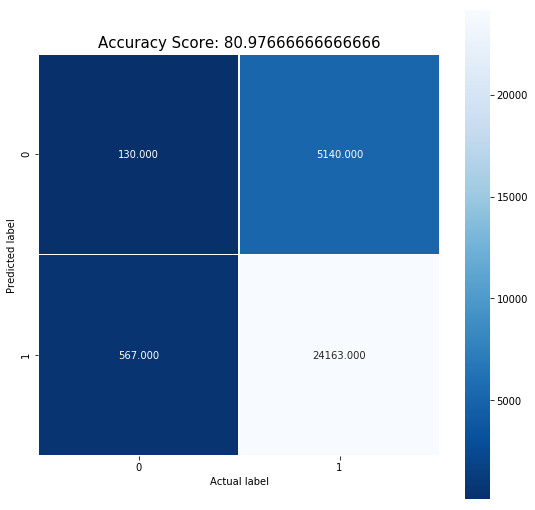


+-------------------------------------------------------------+
| The performance metrics of the above model are as follows:  |
+---------------------------------+---------------------------+
|             Metrics             |           Scores          |
+---------------------------------+---------------------------+
|     Classification_accuracy     |     80.97666666666666     |
|       Classification_error      |     19.023333333333333    |
|          True positive          |           24163           |
|          False positive         |            5140           |
|          True negative          |            130            |
|          False negative         |            567            |
|        True positive rate       |     97.70723817226042     |
|       False negative rate       |     2.2927618277395876    |
|        True negative rate       |     2.4667931688804554    |
|       False positive rate       |     97.53320683111954     |
|         Precision value         |    

In [24]:
Confusion_metric(y_test,avg_pred,avg_acc)

### Hyper-parameter tuning the above model with Grid-search technique

Best: 0.845653 using {'max_depth': 36, 'n_estimators': 400}
0.795738 (0.042554) with: {'max_depth': 10, 'n_estimators': 100}
0.811266 (0.039752) with: {'max_depth': 10, 'n_estimators': 400}
0.816091 (0.035739) with: {'max_depth': 10, 'n_estimators': 600}
0.817610 (0.034130) with: {'max_depth': 10, 'n_estimators': 800}
0.815699 (0.036623) with: {'max_depth': 10, 'n_estimators': 1000}
0.845628 (0.017777) with: {'max_depth': 36, 'n_estimators': 100}
0.845653 (0.017793) with: {'max_depth': 36, 'n_estimators': 400}
0.845628 (0.017820) with: {'max_depth': 36, 'n_estimators': 600}
0.845628 (0.017820) with: {'max_depth': 36, 'n_estimators': 800}
0.845628 (0.017820) with: {'max_depth': 36, 'n_estimators': 1000}
0.845653 (0.017793) with: {'max_depth': 40, 'n_estimators': 100}
0.845628 (0.017820) with: {'max_depth': 40, 'n_estimators': 400}
0.845628 (0.017820) with: {'max_depth': 40, 'n_estimators': 600}
0.845628 (0.017820) with: {'max_depth': 40, 'n_estimators': 800}
0.845628 (0.017820) with: {'

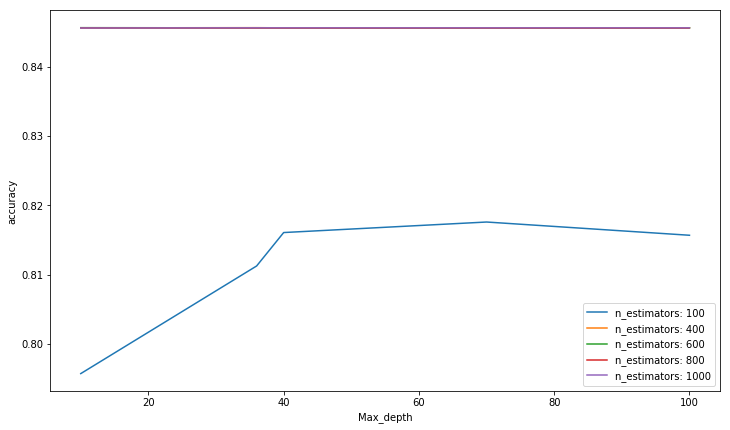

In [25]:
import time
start_time = time.time()

#Tuning the parameters to be given
n_estimators = [100,400,600,800,1000]
max_depth=[10,36,40,70,100]

#Creating dictionary of parameters to be considered
Avg_Param= dict( n_estimators=n_estimators,max_depth=max_depth)

#Hyperarameter tuning the parameters using Gridsearch cross_validation technique
Gridsearch_tuning(Avg_Param,trw2v,y_tr)


print("--- %s seconds ---" % (time.time() - start_time))


### Testing the above model with optimal hyper-parameters

In [26]:
avg_Y_Pred,avg_acc=tuned_test( trw2v,y_tr,testw2v,y_test,400,36)     

The model score on train set is=  0.9836938775510204

The accuracy of the random forest using best parameters over Test set is =  81% 


[[   96  5174]
 [  456 24274]]


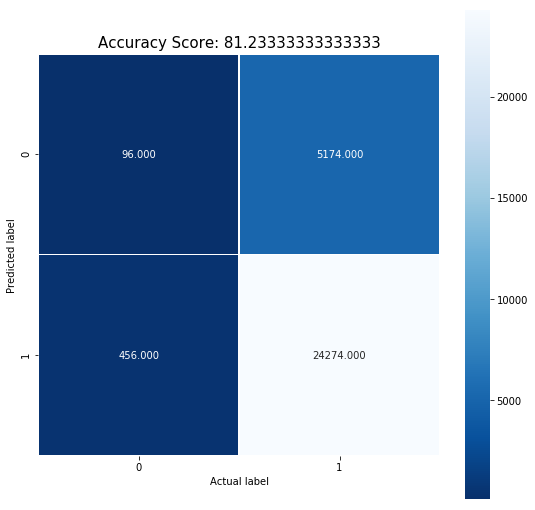


+-------------------------------------------------------------+
| The performance metrics of the above model are as follows:  |
+---------------------------------+---------------------------+
|             Metrics             |           Scores          |
+---------------------------------+---------------------------+
|     Classification_accuracy     |     81.23333333333333     |
|       Classification_error      |     18.76666666666667     |
|          True positive          |           24274           |
|          False positive         |            5174           |
|          True negative          |             96            |
|          False negative         |            456            |
|        True positive rate       |     98.15608572583906     |
|       False negative rate       |     1.843914274160938     |
|        True negative rate       |     1.8216318785578747    |
|       False positive rate       |     98.17836812144213     |
|         Precision value         |    

In [27]:
Confusion_metric(y_test,avg_Y_Pred,avg_acc)

<h3> OBSERVATIONS</h3>
<ul>
    <li>The optimal depth and the number of base learners after doing Gridsearch is 36 and 400 since Random-forest is a low bias and high variance model this parameters are optimal as the variance should be high.</li>
    <li>The test accuracy with optimal parameters is 80.23% which is quite misleading as the performance metrics of the model are model and the model is not at all sensible.</li>
    <li>Since the decision trees did not work well with the high dimensional text data so here random forest also fails because the underlying base-learners are Decison-trees.
    <li>So Random-forest classiffier does not work well with the text data and on the Average word-to vectorization technique.</li>

### Implementing the Tf-IDF Weighted Word2Vec Vectorization technique 

In [28]:

def Tf_idf_vector( X_tr,train_list,test_list,model,words):
    
    Tfidf_vector=TfidfVectorizer()
    Tf_train=Tfidf_vector.fit_transform( X_tr)
    dictionary = dict(zip(Tfidf_vector.get_feature_names(), list(Tfidf_vector.idf_)))
   
    Train_sentence_list=train_list
    Test_sentence_list=test_list
    w2v_words=words
    w2v_model= model
    
    train_list_vector=[]
    row=0
    for sentence in  Train_sentence_list:
        word_2_vec=np.zeros(50)
        weight_tfidf_sum=0
        for word in sentence:
            if word in w2v_words:
                vec=w2v_model.wv[word]
            #tfidf_value=Tf_train[row,Dimension.index(word)]
                tf_idf = dictionary[word]*sentence.count(word)
                word_2_vec +=(vec *tf_idf)
                weight_tfidf_sum +=tf_idf
        if weight_tfidf_sum !=0:
            word_2_vec /=weight_tfidf_sum
        train_list_vector.append(word_2_vec)
        row +=1
    print(len(train_list_vector))
    print(len(train_list_vector[0]))

    
    TEST_LIST_VECTOR=[]
    Row=0
    for sentence in  Test_sentence_list:
        word_2_vec=np.zeros(50)
        weight_tf_sum=0
        for word in sentence:
            if word in w2v_words:
                vec=w2v_model.wv[word]
            #tfidf_value=Tf_test[Row,Dimension.index(word)]
                tf_idf = dictionary[word]*sentence.count(word)
                word_2_vec += (vec* tf_idf)
                weight_tf_sum += tf_idf
        if weight_tf_sum !=0:
            word_2_vec /=weight_tf_sum
        TEST_LIST_VECTOR.append(word_2_vec)
        row += 1
    print(len(TEST_LIST_VECTOR))
    print(len(TEST_LIST_VECTOR[0]))

    return train_list_vector,TEST_LIST_VECTOR




### Preparing the datapoints for the Tf-Idf weighted vectorization technique 

In [29]:
Xtrain=X_tr["CleanedText"]

tfidf_tr,tfidf_test=Tf_idf_vector(Xtrain,tr_list,tes_list,model,words)

49000
50
30000
50


### Training the model over the default parameters

In [30]:
tfw2v_pred,tfw2v_acc=train(tfidf_tr,y_tr,tfidf_test,y_test)

The model score on train set is=  0.9757755102040816

The accuracy of Random-forest over cross-validation set is =  80% 


### Confusion matrix of the above model 

In [ ]:
Confusion_metric(y_test,avg_Y_Pred,avg_acc)

Best: 0.845628 using {'max_depth': 36, 'n_estimators': 100}
0.804213 (0.041811) with: {'max_depth': 10, 'n_estimators': 100}
0.818540 (0.034875) with: {'max_depth': 10, 'n_estimators': 400}
0.819324 (0.033787) with: {'max_depth': 10, 'n_estimators': 600}
0.820402 (0.034054) with: {'max_depth': 10, 'n_estimators': 800}
0.820598 (0.033677) with: {'max_depth': 10, 'n_estimators': 1000}
0.845628 (0.017806) with: {'max_depth': 36, 'n_estimators': 100}
0.845604 (0.017827) with: {'max_depth': 36, 'n_estimators': 400}
0.845579 (0.017834) with: {'max_depth': 36, 'n_estimators': 600}
0.845604 (0.017827) with: {'max_depth': 36, 'n_estimators': 800}
0.845604 (0.017827) with: {'max_depth': 36, 'n_estimators': 1000}
0.845604 (0.017827) with: {'max_depth': 40, 'n_estimators': 100}
0.845604 (0.017827) with: {'max_depth': 40, 'n_estimators': 400}
0.845604 (0.017827) with: {'max_depth': 40, 'n_estimators': 600}
0.845604 (0.017827) with: {'max_depth': 40, 'n_estimators': 800}
0.845604 (0.017827) with: {'

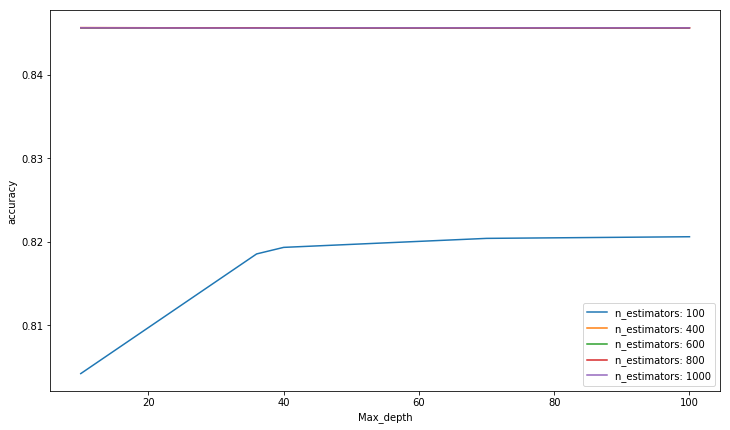

In [31]:
import time
start_time = time.time()

#Tuning the parameters to be given
n_estimators = [100,400,600,800,1000]
max_depth=[10,36,40,70,100]

#Creating dictionary of parameters to be considered
tfw2v_Param= dict( n_estimators=n_estimators,max_depth=max_depth)

#Hyperarameter tuning the parameters using Gridsearch cross_validation technique
Gridsearch_tuning(tfw2v_Param,tfidf_tr,y_tr)


print("--- %s seconds ---" % (time.time() - start_time))


### Testing the data with optimal hyperparameters

In [32]:
tfw2v_Y_Pred,tfw2v_Acc=tuned_test( tfidf_tr,y_tr,tfidf_test,y_test,100,36)     

The model score on train set is=  0.9837959183673469

The accuracy of the random forest using best parameters over Test set is =  81% 


### Confusion matrix of the above model

[[   96  5174]
 [  456 24274]]


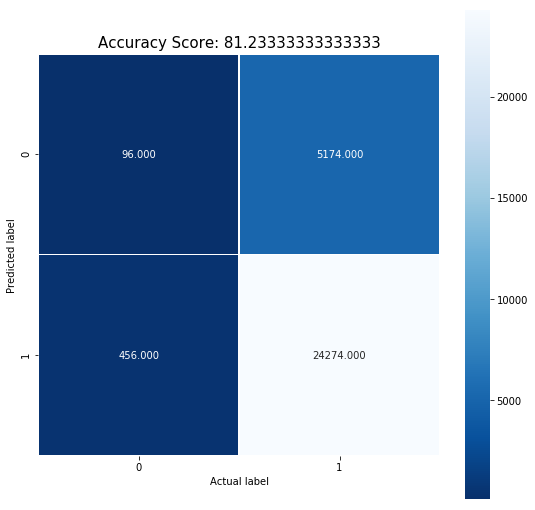


+-------------------------------------------------------------+
| The performance metrics of the above model are as follows:  |
+---------------------------------+---------------------------+
|             Metrics             |           Scores          |
+---------------------------------+---------------------------+
|     Classification_accuracy     |     81.23333333333333     |
|       Classification_error      |     18.76666666666667     |
|          True positive          |           24274           |
|          False positive         |            5174           |
|          True negative          |             96            |
|          False negative         |            456            |
|        True positive rate       |     98.15608572583906     |
|       False negative rate       |     1.843914274160938     |
|        True negative rate       |     1.8216318785578747    |
|       False positive rate       |     98.17836812144213     |
|         Precision value         |    

In [33]:
Confusion_metric(y_test,tfw2v_Y_Pred,tfw2v_Acc)

<h3> OBSERVATIONS</h3>
<ul>
    <li>The optimal depth and the number of base learners after doing Gridsearch is 36 and 100 since Random-forest is a low bias and high variance model this parameters are optimal as the variance should be high.</li>
    <li>The test accuracy with optimal parameters is 81.23% which is quite misleading as the performance metrics of the model are model and the model is not at all sensible.</li>
    <li>Since the decision trees did not work well with the high dimensional text data so here random forest also fails because the underlying base-learners are Decison-trees.
    <li>So Random-forest classiffier does not work well with the text data and on the Tf-idf weighted word2vector vectorization.</li>

<h2>Conclusion</h2>
<ul>
    <li>By studying the performance of Random forest classiffier on all the vectorization technique it is clear that random forest does not work well for high dimensional text data.</li>
    <li>For optimal performance of the number of base learners must be high and same as the depth of the tree since random forest is a bagging algorithm of low bias and high variance model.</li>
        
